In [1]:
import os
import random 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pickle
import keras

## Changing work Directory

In [2]:
os.chdir(r"\Users\Shaimaa Said\Desktop\Face Mask Detection")
print(os.getcwd())

C:\Users\Shaimaa Said\Desktop\Face Mask Detection


In [3]:
print(os.getcwd())

C:\Users\Shaimaa Said\Desktop\Face Mask Detection


## Fetch images from their Directory

In [4]:
from glob import glob
from pathlib import Path
print(os.getcwd())
DATASET_DIR = r"FullData"
print(DATASET_DIR)

all_data = [y for x in os.walk(DATASET_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
all_labels = [os.path.basename(x).split('_',1)[1].split('.')[0] for x in all_data]
print(len(all_data))


C:\Users\Shaimaa Said\Desktop\Face Mask Detection
FullData
47331


In [5]:
unique_val, counts = np.unique(all_labels, return_counts=True)
print(unique_val, counts)

['Mask' 'Mask_Chin' 'Mask_Mouth_Chin' 'Mask_Nose_Mouth'] [ 9367  2690 31712  3562]


## Plot Random images from the dataset

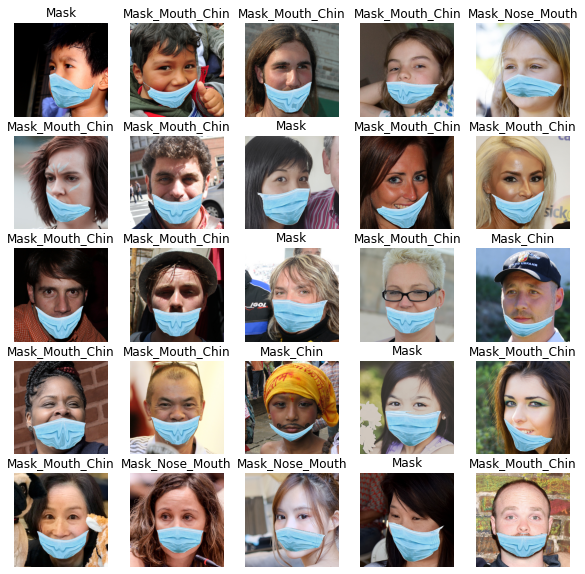

In [6]:
# Sample 25 images from dataset
indices = np.random.randint(0, len(all_data), size=25)
pt_images = [all_data[i] for i in indices]
pt_labels = [all_labels[i] for i in indices]

# Plot the 25 images
plt.figure(figsize=(10,10))
for i in range(len(indices)):
    plt.subplot(5, 5, i + 1)
    image = mpimg.imread(pt_images[i]) # Read image from disk
    plt.imshow(image)
    plt.title(pt_labels[i])
    plt.axis('off')
    
plt.show()

## Data Splitting

In [7]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.1, random_state=10)

In [8]:
data_train = np.append(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1), axis=1)
data_test = np.append(np.array(X_test).reshape(-1,1),np.array(y_test).reshape(-1,1), axis=1)

In [9]:
df_train = pd.DataFrame (data_train,columns=['image', 'label'])
df_test = pd.DataFrame (data_test,columns=['image', 'label'])

In [10]:
df_train.head(5)

,image,label
0,FullData\IMFD\44000\44204_Mask_Mouth_Chin.jpg,Mask_Mouth_Chin
1,FullData\CMFD\01000\01405_Mask.jpg,Mask
2,FullData\IMFD\38000\38457_Mask_Chin.jpg,Mask_Chin
3,FullData\IMFD\46000\46232_Mask_Mouth_Chin.jpg,Mask_Mouth_Chin
4,FullData\IMFD\36000\36851_Mask_Mouth_Chin.jpg,Mask_Mouth_Chin


## Balancing the dataset

In [11]:
#class_0_under = df_train[df_train['label'] == 'Mask'].sample(2600)
#class_1 = df_train[df_train['label'] == 'Mask_Chin'].sample(2600)
#class_2_under = df_train[df_train['label'] == 'Mask_Mouth_Chin'].sample(2600)
#class_3 = df_train[df_train['label'] == 'Mask_Nose_Mouth'].sample(2600)

#df_train = pd.concat([class_0_under, class_1, class_2_under, class_3], axis=0)

In [12]:
#sns.countplot('label', data=df_train)
#plt.title("Face Mask distribution")

# Load Data

In [13]:
BATCH_SIZE = 64
HEIGHT = 224
WIDTH = 224
VAL_SPLIT = 0.2

# 1. Construct an instance of the `ImageDataGenerator` class
train_datagen =  ImageDataGenerator(
      preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
      width_shift_range=0.1,
      height_shift_range=0.1,
      rotation_range=20,
      zoom_range=[0.9,1.1],
      brightness_range=[0.8,1],
      horizontal_flip=True,
      validation_split = VAL_SPLIT
    )


In [14]:
# 2. Retrieve the iterator
train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='image',
                                                    y_col='label',
                                                    shuffle = True,
                                                    seed = 10,
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')
val_generator = train_datagen.flow_from_dataframe(df_train,
                                                  x_col='image',
                                                  y_col='label',
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle = True,
                                                  seed = 10,
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  subset='validation')

Found 34078 validated image filenames belonging to 4 classes.
Found 8519 validated image filenames belonging to 4 classes.


In [15]:
# Do the same steps for the test set

# 1. Construct an instance of the `ImageDataGenerator` class
test_datagen =  ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
    )

# 2. Retrieve the iterator
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  x_col='image',
                                                  y_col='label', 
                                                  target_size=(HEIGHT, WIDTH), 
                                                  batch_size=32,
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 4734 validated image filenames belonging to 4 classes.


# Model

In [16]:
# Load the pretained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(HEIGHT, WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable = False

In [17]:
# Add new classifier layers

# Use a Sequential model to add a trainable classifier on top
model = keras.Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])


# Print summary
#model.summary()

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['AUC'])

In [18]:
INITIAL_EPOCHS = 10

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = INITIAL_EPOCHS)

Epoch 1/10
533/533 [==============================] - 4162s 8s/step - loss: 0.3091 - auc: 0.9775 - val_loss: 0.0861 - val_auc: 0.9984
Epoch 2/10
533/533 [==============================] - 3705s 7s/step - loss: 0.1154 - auc: 0.9968 - val_loss: 0.0713 - val_auc: 0.9986
Epoch 3/10
533/533 [==============================] - 3830s 7s/step - loss: 0.0948 - auc: 0.9977 - val_loss: 0.0636 - val_auc: 0.9991
Epoch 4/10
533/533 [==============================] - 4156s 8s/step - loss: 0.0866 - auc: 0.9980 - val_loss: 0.0908 - val_auc: 0.9981
Epoch 5/10
533/533 [==============================] - 4385s 8s/step - loss: 0.0785 - auc: 0.9985 - val_loss: 0.0599 - val_auc: 0.9989
Epoch 6/10
533/533 [==============================] - 3822s 7s/step - loss: 0.0749 - auc: 0.9984 - val_loss: 0.0559 - val_auc: 0.9993
Epoch 7/10
533/533 [==============================] - 4052s 8s/step - loss: 0.0722 - auc: 0.9986 - val_loss: 0.0684 - val_auc: 0.9987
Epoch 8/10
533/533 [==============================] - 3807s 7s

## Plotting Learning curves

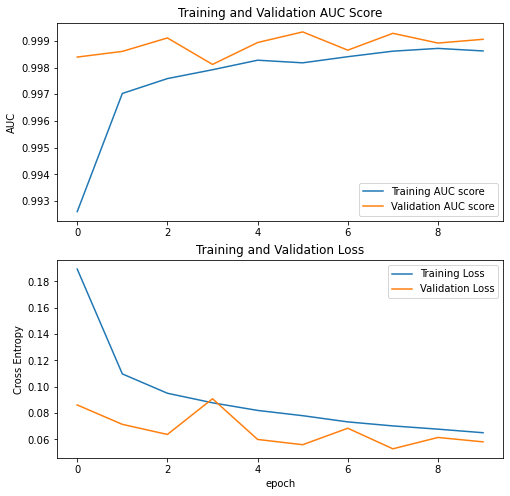

In [19]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training AUC score')
plt.plot(val_acc, label='Validation AUC score')
plt.legend(loc='lower right')
plt.ylabel('AUC')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC Score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
#Saving the model to be used later
model.save('AUC_mod2', save_format='hdf5')

C:\Users\Shaimaa Said\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: AUC_mod2\assets


# Evaluation

In [16]:
model = load_model('AUC_mod2')

In [17]:
model.evaluate(test_generator)

48/48 [==============================] - 22s 52ms/step - loss: 0.1708 - auc: 0.9864


[0.17078346014022827, 0.9864005446434021]

In [21]:
# Predict the label of the test_images
pred = model.predict(test_generator)
pred = np.argmax(pred,axis=1)

# Map the label
unique_labels = (train_generator.class_indices)
unique_labels = dict((v,k) for k,v in unique_labels.items())
pred = [unique_labels[k] for k in pred]

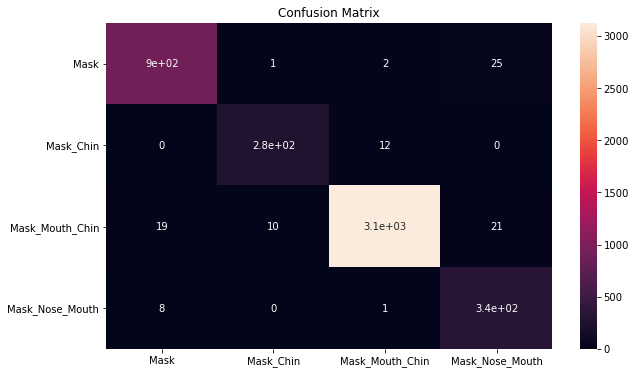

In [22]:
cf_matrix = confusion_matrix(y_test, pred)
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.show()

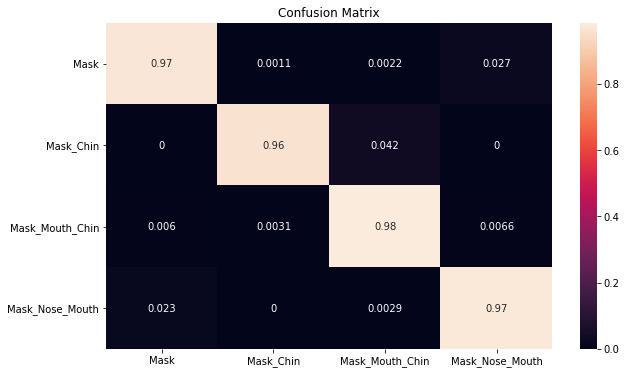

In [24]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.show()

In [23]:
print(classification_report(y_test,pred))

                 precision    recall  f1-score   support

           Mask       0.97      0.97      0.97       923
      Mask_Chin       0.96      0.96      0.96       287
Mask_Mouth_Chin       1.00      0.98      0.99      3176
Mask_Nose_Mouth       0.88      0.97      0.92       348

       accuracy                           0.98      4734
      macro avg       0.95      0.97      0.96      4734
   weighted avg       0.98      0.98      0.98      4734



## Loading another model

In [ ]:
small_data_model = load_model('assets')

In [ ]:
# Predict the label of the test_images
pred = small_data_model.predict(test_generator)
pred = np.argmax(pred,axis=1)

# Map the label
unique_labels = (train_generator.class_indices)
unique_labels = dict((v,k) for k,v in unique_labels.items())
pred = [unique_labels[k] for k in pred]

In [ ]:
cf_matrix = confusion_matrix(y_test, pred)
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install h5py

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow